<a href="https://colab.research.google.com/github/ChahineBA/Digit-Recognition/blob/main/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
#Load Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2 as cv

from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle

%matplotlib inline

**About Dataset**
MNIST dataset has the following features:

* Dataset size 60,000 samples of handwritten images.
* The size of each image is 28x28 pixels.
* Each image has only 1 color channel, i.e., grayscale image.
* Each pixel has value in the range of [0,255] where 0 represents black, and 255 represents white.
* Each image has labeled from 0-9.

In [ ]:
#Datasets:
np.random.seed(1)
df_train = pd.read_csv('/content/train.csv')

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.shape

(42000, 785)

Training set has 42,000 images. And has 785 columns, 1st coloumn is label for the image and rest 784 are the pixel values.
Remember **it is flattened. I will reshape it latter.**

# Preparing Training and Validation data

In [ ]:
sample_size = df_train.shape[0] # Training set size
validation_size = int(df_train.shape[0]*0.1) # Validation set size

# train_x and train_y
train_x = np.asarray(df_train.iloc[:sample_size-validation_size,1:]).reshape([sample_size-validation_size,28,28,1]) # taking all columns expect column 0
train_y = np.asarray(df_train.iloc[:sample_size-validation_size,0]).reshape([sample_size-validation_size,1]) # taking column 0

# val_x and val_y
val_x = np.asarray(df_train.iloc[sample_size-validation_size:,1:]).reshape([validation_size,28,28,1])
val_y = np.asarray(df_train.iloc[sample_size-validation_size:,0]).reshape([validation_size,1])

In [ ]:
train_x.shape,train_y.shape

((37800, 28, 28, 1), (37800, 1))

In [ ]:
df_test = pd.read_csv("/content/test.csv")
test_x = np.asarray(df_test.iloc[:,:]).reshape([-1,28,28,1])

In [ ]:
#Normalize Pixels:
train_x = train_x/255
val_x = val_x/255
test_x = test_x/255

In [ ]:
counts = df_train.iloc[:sample_size-validation_size,:].groupby('label')['label'].count()
counts

label
0    3677
1    4226
2    3785
3    3903
4    3634
5    3441
6    3724
7    3980
8    3666
9    3764
Name: label, dtype: int64

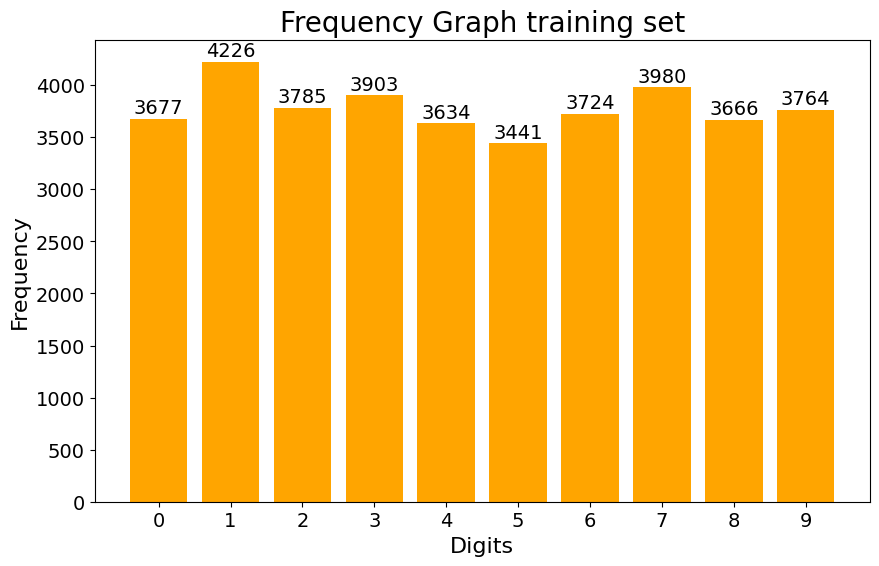

In [ ]:
# Cheacking frequency of digits in training and validation set
counts = df_train.iloc[:sample_size-validation_size,:].groupby('label')['label'].count()
# df_train.head(2)
# counts
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+50,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph training set",fontsize=20)
plt.savefig('digit_frequency_train.png')
plt.show()

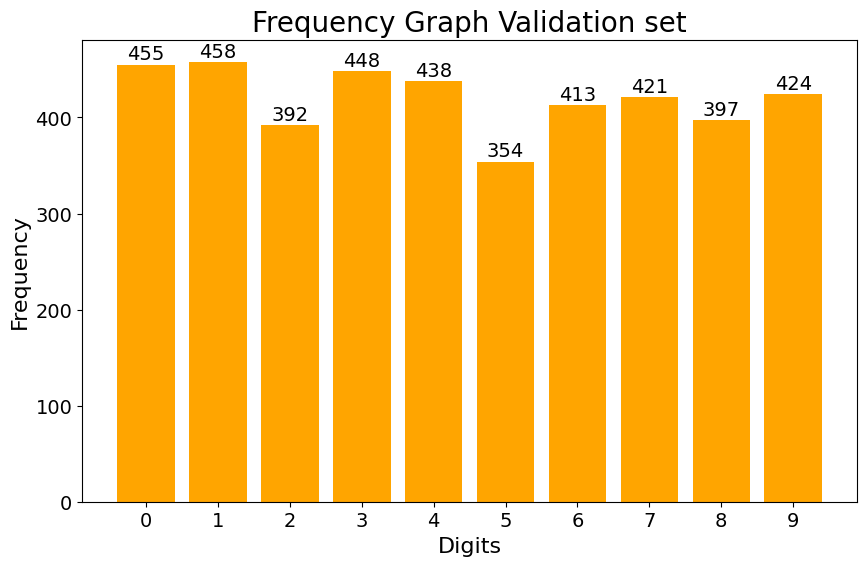

In [ ]:
# df_train.iloc[sample_size-validation_index:,1:]
# Cheacking frequency of digits in training and validation set
counts = df_train.iloc[sample_size-validation_size:,:].groupby('label')['label'].count()
# df_train.head(2)
# counts
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+5,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph Validation set",fontsize=20)
plt.savefig('digit_frequency_val.png')
plt.show()

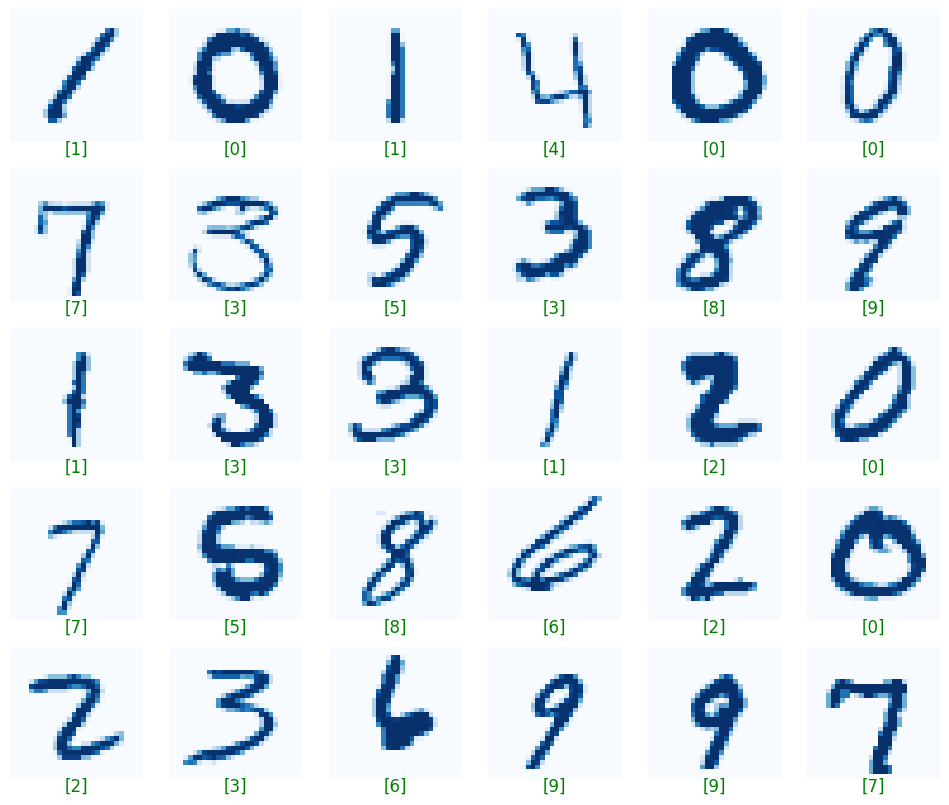

In [ ]:
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows)) # defining a figure

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train_x[i].reshape([28,28]),cmap="Blues")
    plt.axis("off")
    plt.title(str(train_y[i]), y=-0.15,color="green")
plt.savefig("digits.png")

# Model

In [ ]:
model = models.Sequential()

In [ ]:
# Block 1
model.add(Conv2D(32,3, padding  ="same",input_shape=(28,28,1)))
model.add(LeakyReLU())
model.add(Conv2D(32,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# Block 2
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation="sigmoid"))

In [ ]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(learning_rate=initial_lr), loss=loss ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                        

In [ ]:
epochs = 20
batch_size = 256
history_1 = model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,validation_data=[val_x,val_y])

Epoch 1/20
148/148 [==============================] - 160s 1s/step - loss: 0.3562 - accuracy: 0.8848 - val_loss: 0.0833 - val_accuracy: 0.9745
Epoch 2/20
148/148 [==============================] - 151s 1s/step - loss: 0.0772 - accuracy: 0.9771 - val_loss: 0.0561 - val_accuracy: 0.9814
Epoch 3/20
148/148 [==============================] - 151s 1s/step - loss: 0.0520 - accuracy: 0.9842 - val_loss: 0.0431 - val_accuracy: 0.9857
Epoch 4/20
148/148 [==============================] - 152s 1s/step - loss: 0.0391 - accuracy: 0.9876 - val_loss: 0.0475 - val_accuracy: 0.9840
Epoch 5/20
148/148 [==============================] - 151s 1s/step - loss: 0.0340 - accuracy: 0.9894 - val_loss: 0.0346 - val_accuracy: 0.9890
Epoch 6/20
148/148 [==============================] - 153s 1s/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.0391 - val_accuracy: 0.9881
Epoch 7/20
148/148 [==============================] - 150s 1s/step - loss: 0.0222 - accuracy: 0.9930 - val_loss: 0.0387 - val_accuracy: 0.9874

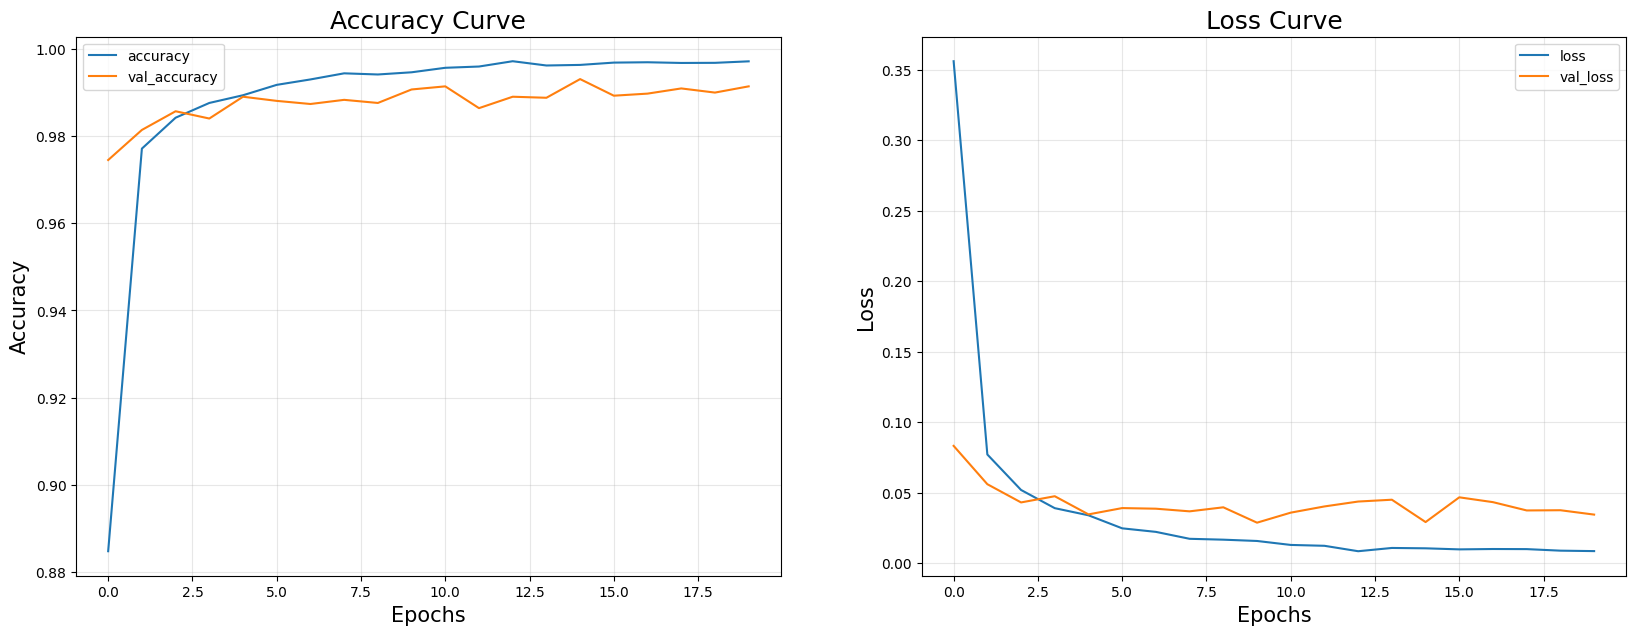

In [ ]:
# Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(history_1.epoch,history_1.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch,history_1.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch,history_1.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch,history_1.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1

print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])

132/132 [==============================] - 5s 38ms/step
Confusion Matrix: 

 [[454.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0. 456.   0.   0.   0.   0.   1.   1.   0.   0.]
 [  3.   0. 385.   1.   0.   0.   0.   2.   0.   1.]
 [  1.   0.   0. 446.   0.   1.   0.   0.   0.   0.]
 [  0.   1.   0.   0. 435.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   3.   0. 350.   1.   0.   0.   0.]
 [  3.   0.   0.   0.   1.   0. 409.   0.   0.   0.]
 [  0.   1.   3.   0.   0.   0.   0. 417.   0.   0.]
 [  0.   0.   2.   2.   0.   3.   0.   0. 390.   0.]
 [  1.   0.   0.   2.  12.   0.   0.   3.   3. 403.]]

Errors in validation set:  55

Error Persentage :  1.3095238095238095

Accuracy :  98.69047619047619

Validation set Shape : 4200


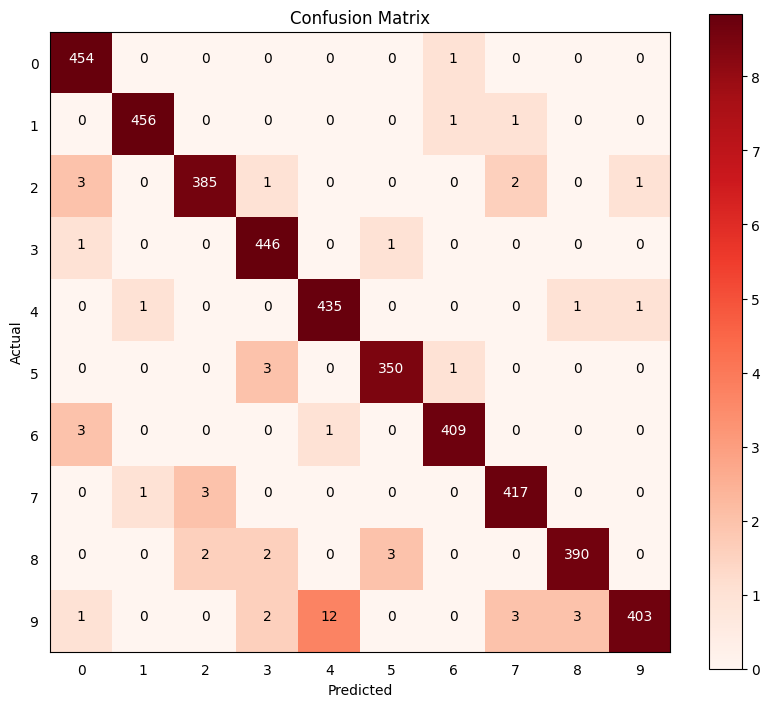

In [ ]:
f = plt.figure(figsize=(10,8.5))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix+1),cmap="Reds")
plt.colorbar()
plt.tick_params(size=5,color="white")
plt.xticks(np.arange(0,10),np.arange(0,10))
plt.yticks(np.arange(0,10),np.arange(0,10))

threshold = confusion_matrix.max()/2

for i in range(10):
    for j in range(10):
        plt.text(j,i,int(confusion_matrix[i,j]),horizontalalignment="center",color="white" if confusion_matrix[i, j] > threshold else "black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix1.png")
plt.show()

# Image Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

In [ ]:
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
epochs = 20
history_2 = model.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),steps_per_epoch=int(train_x.shape[0]/batch_size)+1,epochs=epochs,validation_data=[val_x,val_y],callbacks=[lrr])

<ipython-input-29-ef36dd8af4af>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),steps_per_epoch=int(train_x.shape[0]/batch_size)+1,epochs=epochs,validation_data=[val_x,val_y],callbacks=[lrr])


Epoch 1/20
148/148 [==============================] - 175s 1s/step - loss: 0.1273 - accuracy: 0.9633 - val_loss: 0.0285 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - 185s 1s/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.0269 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9840
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
148/148 [==============================] - 166s 1s/step - loss: 0.0523 - accuracy: 0.9840 - val_loss: 0.0348 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/20
148/148 [==============================] - 166s 1s/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.0184 - val_accuracy: 0.9936 - lr: 5.0000e-04
Epoch 5/20
148/148 [==============================] - 164s 1s/step - loss: 0.0339 - accuracy: 0.9885 - val_loss: 0.0249 - val_accuracy: 0.9924 - lr: 5.0000e-04
Epoch 6/20
148/148 [==============================]

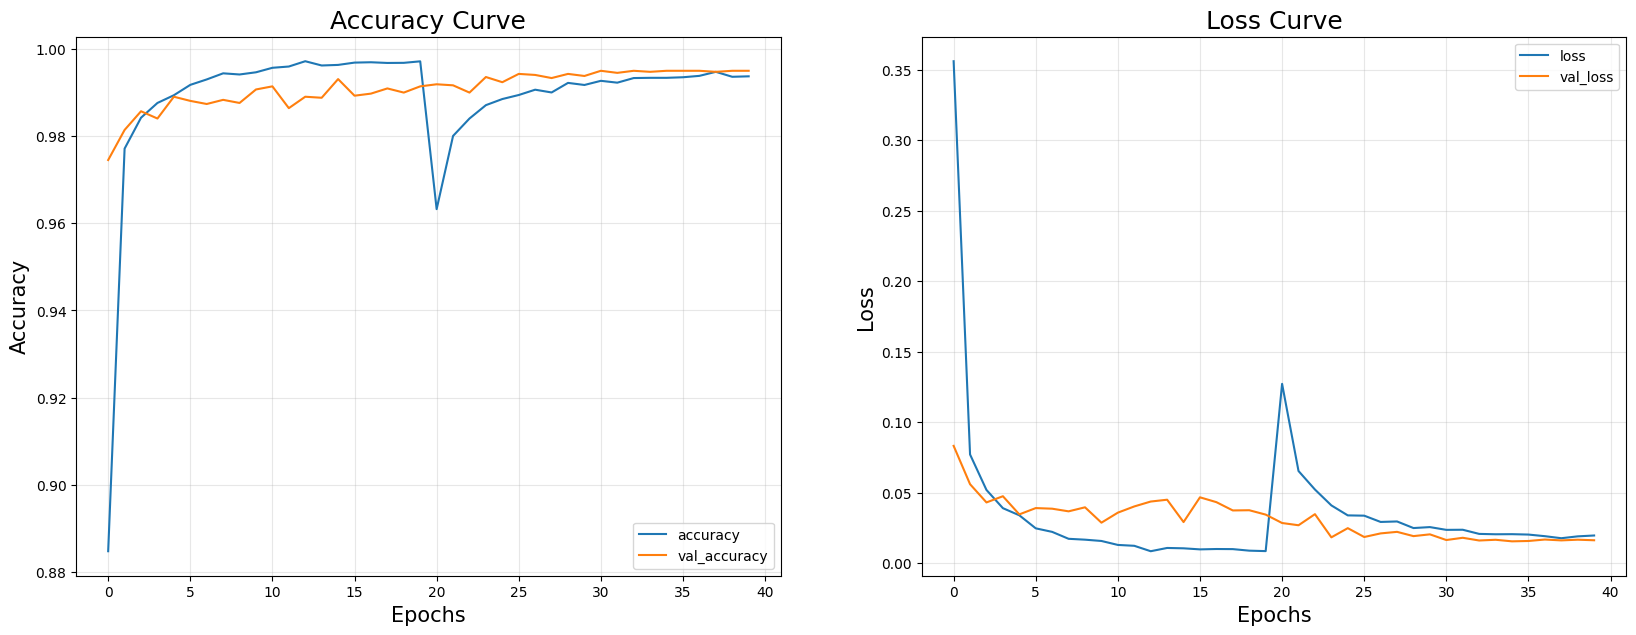

In [ ]:
# Diffining Figure
f = plt.figure(figsize=(20,7))
f.add_subplot(121)

#Adding Subplot 1 (For Accuracy)
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['accuracy']+history_2.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_accuracy']+history_2.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['loss']+history_2.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_loss']+history_2.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1

confusion_matrix,error,(error*100)/val_p.shape[0],100-(error*100)/val_p.shape[0],val_p.shape[0]

print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])

132/132 [==============================] - 5s 36ms/step
Confusion Matrix: 

 [[454.   0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0. 454.   1.   0.   0.   0.   1.   2.   0.   0.]
 [  2.   0. 390.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 447.   0.   0.   0.   0.   0.   1.]
 [  0.   1.   0.   0. 436.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0. 352.   1.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0. 413.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0. 419.   0.   1.]
 [  0.   0.   0.   2.   0.   0.   0.   0. 395.   0.]
 [  0.   0.   0.   1.   0.   1.   0.   0.   3. 419.]]

Errors in validation set:  21

Error Persentage :  0.5

Accuracy :  99.5

Validation set Shape : 4200


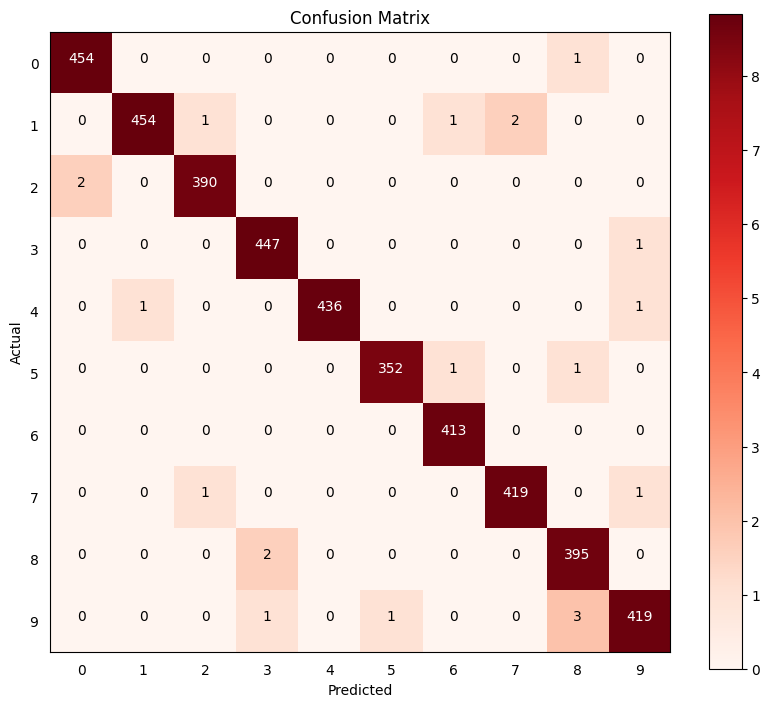

In [ ]:
f = plt.figure(figsize=(10,8.5))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix+1),cmap="Reds")
plt.colorbar()
plt.tick_params(size=5,color="white")
plt.xticks(np.arange(0,10),np.arange(0,10))
plt.yticks(np.arange(0,10),np.arange(0,10))

threshold = confusion_matrix.max()/2

for i in range(10):
    for j in range(10):
        plt.text(j,i,int(confusion_matrix[i,j]),horizontalalignment="center",color="white" if confusion_matrix[i, j] > threshold else "black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix2.png")
plt.show()

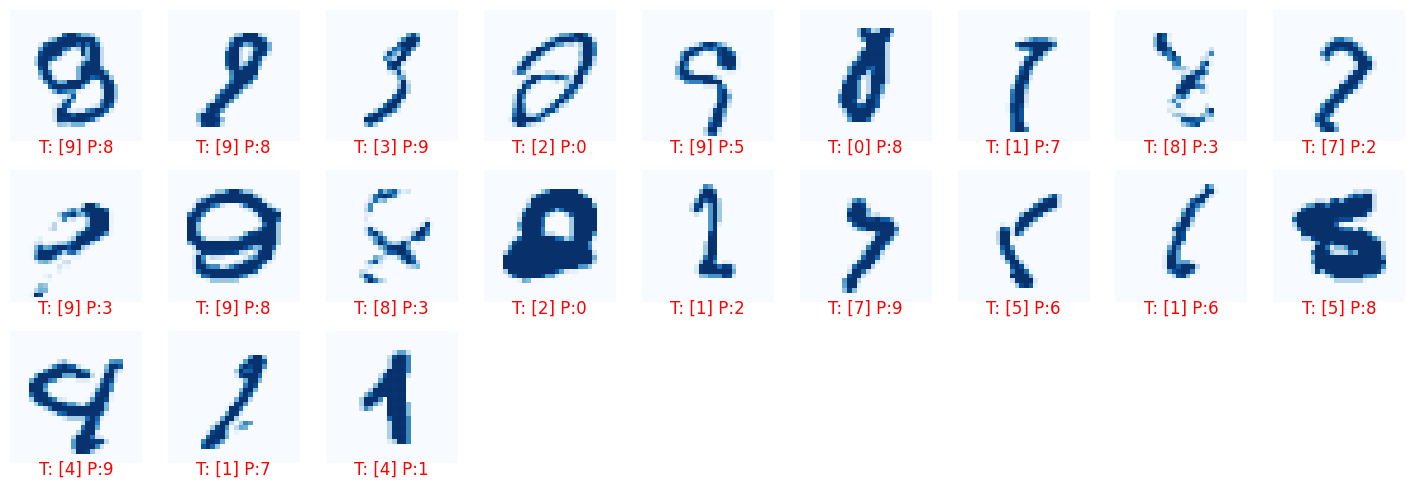

In [ ]:
rows = 4
cols = 9

f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1
for i in range(val_x.shape[0]):
    if val_y[i]!=val_p[i]:
        f.add_subplot(rows,cols,sub_plot)
        sub_plot+=1
        plt.imshow(val_x[i].reshape([28,28]),cmap="Blues")
        plt.axis("off")
        plt.title("T: "+str(val_y[i])+" P:"+str(val_p[i]), y=-0.15,color="Red")
plt.savefig("error_plots.png")
plt.show()

In [ ]:
test_y = np.argmax(model.predict(test_x),axis =1)

875/875 [==============================] - 38s 43ms/step


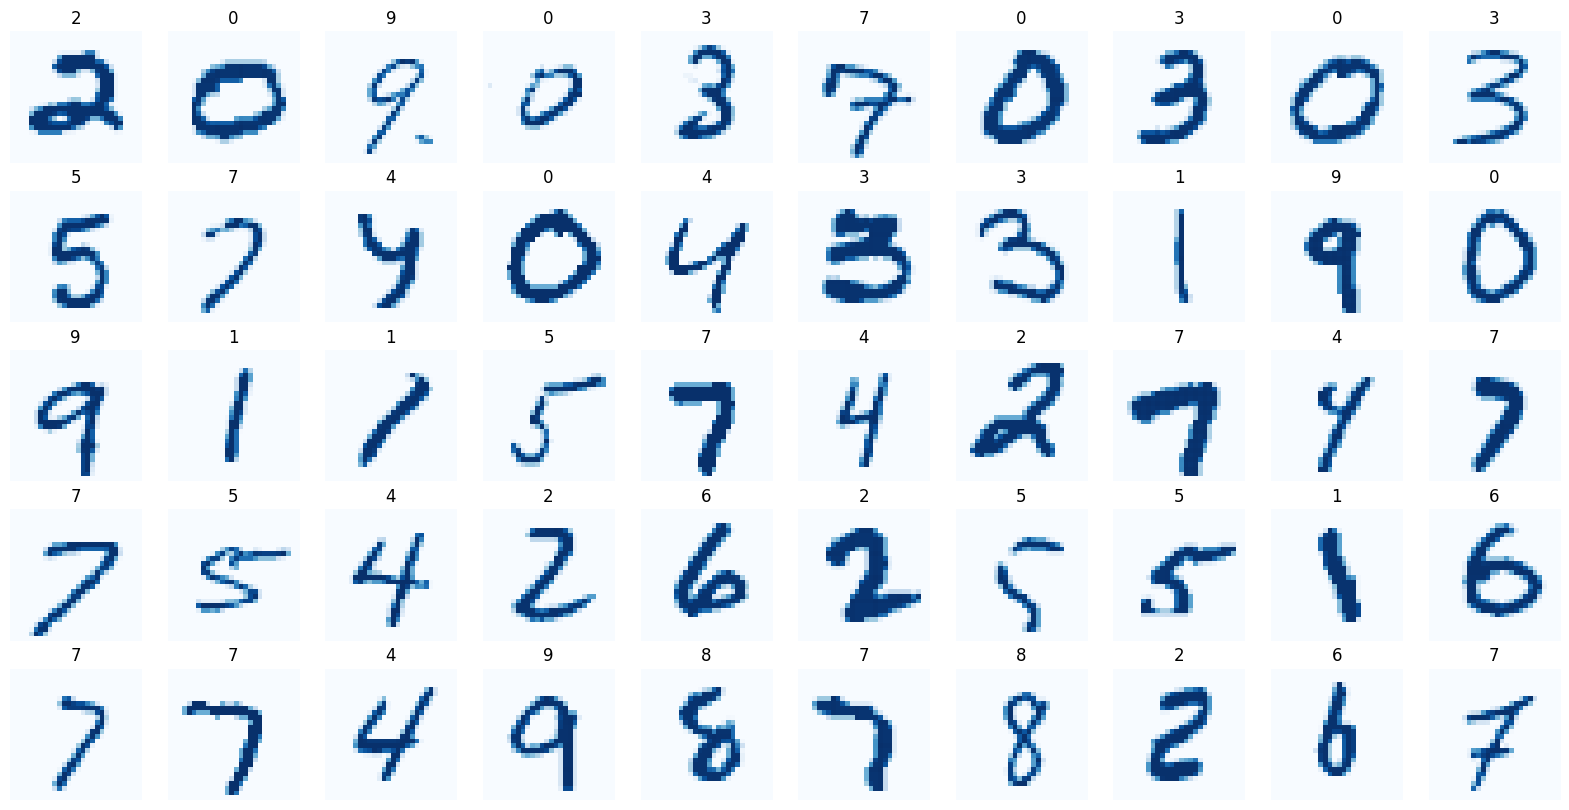

In [ ]:
rows = 5
cols = 10

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(test_x[i].reshape([28,28]),cmap="Blues")
    plt.axis("off")
    plt.title(str(test_y[i]))

In [ ]:
# Extracts the outputs of all layers except Flatten and Dense layers
output_layers = [layer.output for layer in model.layers[:-4]]
# Creates a model that will return these outputs, given the model input (This is multi output model)
activation_model = models.Model(inputs=model.input, outputs=output_layers)

In [ ]:
# predicting the output of each layers
activations_2  = activation_model.predict(val_x[2].reshape([1,28,28,1]))
activations_6  = activation_model.predict(val_x[7].reshape([1,28,28,1]))
first_activation_layer  = activations_2[0]
first_activation_layer.shape

1/1 [==============================] - 0s 39ms/step


(1, 28, 28, 32)

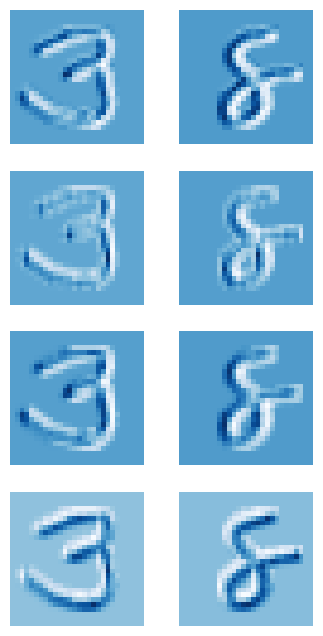

In [ ]:
rows = 4
cols = 2

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(4):
    f.add_subplot(rows,cols,2*i+1)
    plt.imshow(activations_2[0][0,:,:,i].reshape([28,28]),cmap="Blues")
    plt.axis("off")

    f.add_subplot(rows,cols,2*i+2)
    plt.imshow(activations_6[0][0,:,:,i].reshape([28,28]),cmap="Blues")
    plt.savefig("layer_output_comparision"+str(i)+".png")
    plt.axis("off")

In [ ]:
def plot_layer(layer,i,layer_name = None):
    rows = int(layer.shape[-1]/16)
    cols = 16

    f = plt.figure(figsize=(1*cols,1*rows))
    # plt.imshow(first_activation_layer[0,:,:,:].reshape([14*4,14*16]),cmap="Blues")
    for i in range(layer.shape[-1]):
        f.add_subplot(rows,cols,i+1)
        plt.imshow(layer[0,:,:,i].reshape([layer.shape[2],layer.shape[2]]),cmap="Blues")
        plt.axis("off")
    f.suptitle(layer_name,fontsize=14)
    plt.savefig("intermidiate_layers"+str(i)+".png")
    plt.show()

1/1 [==============================] - 0s 27ms/step


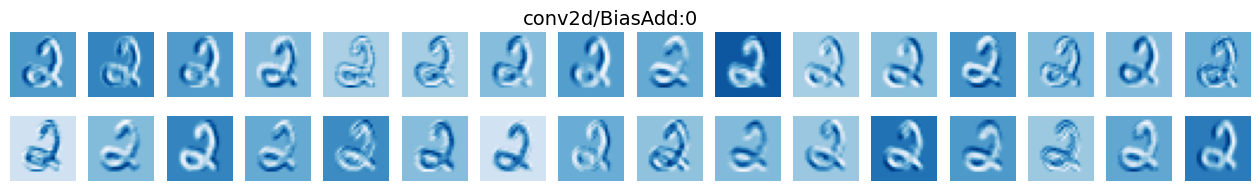

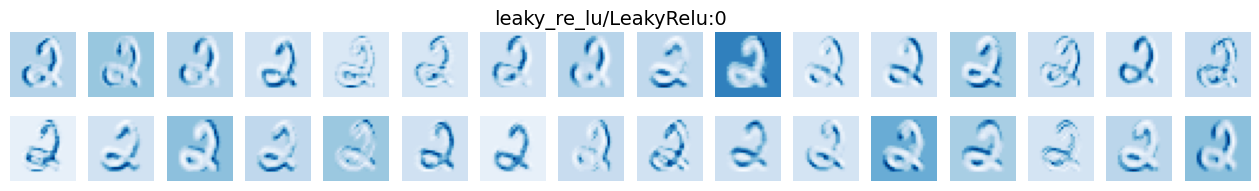

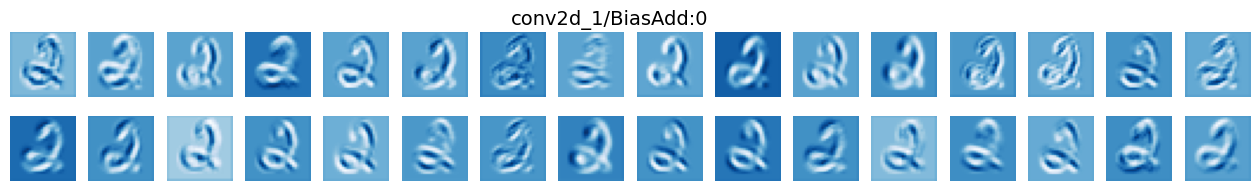

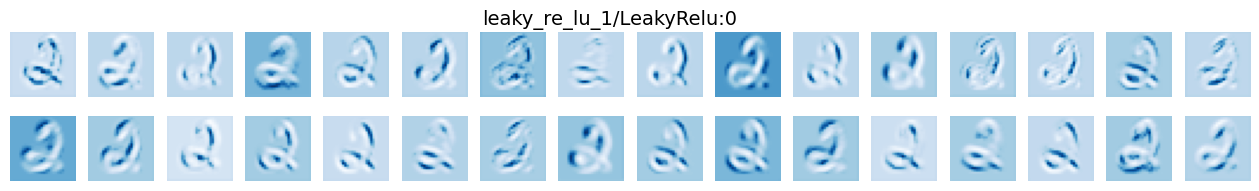

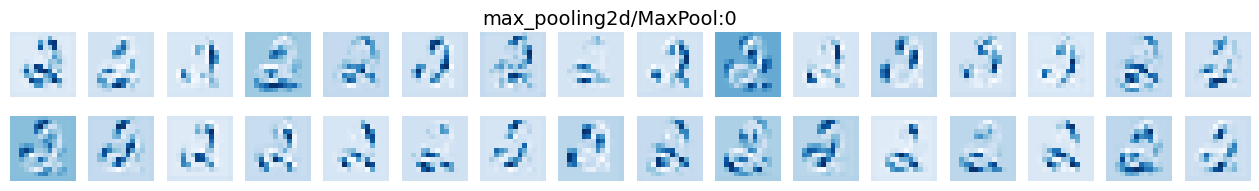

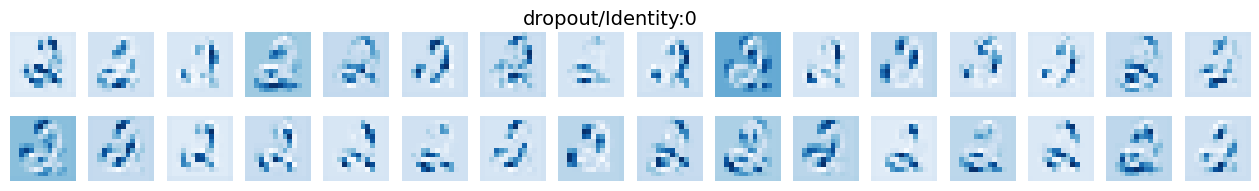

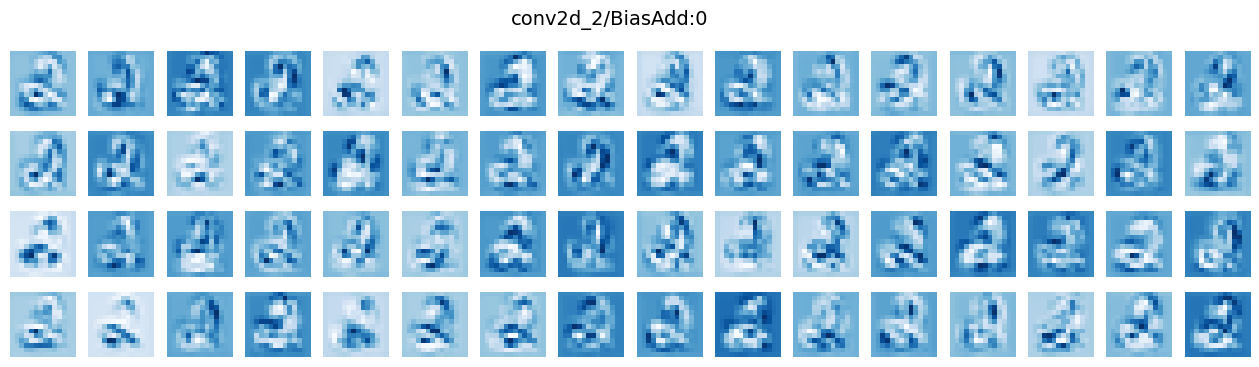

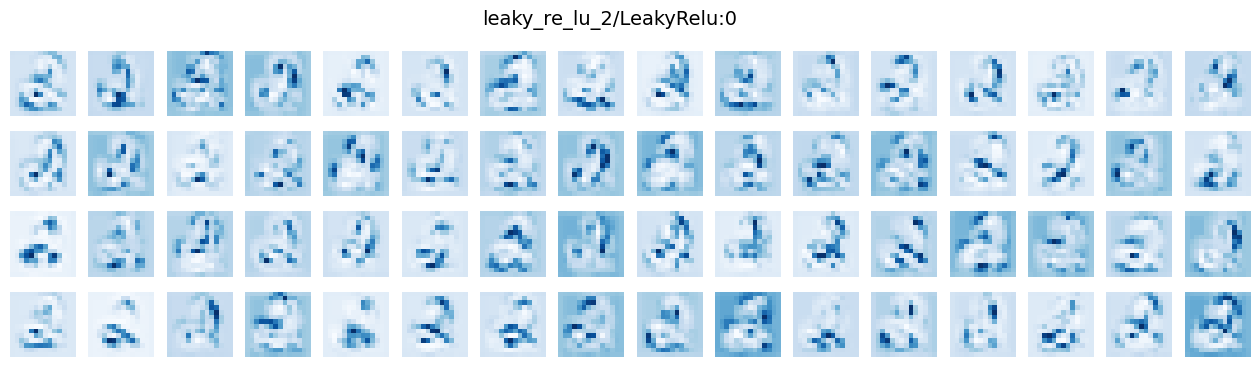

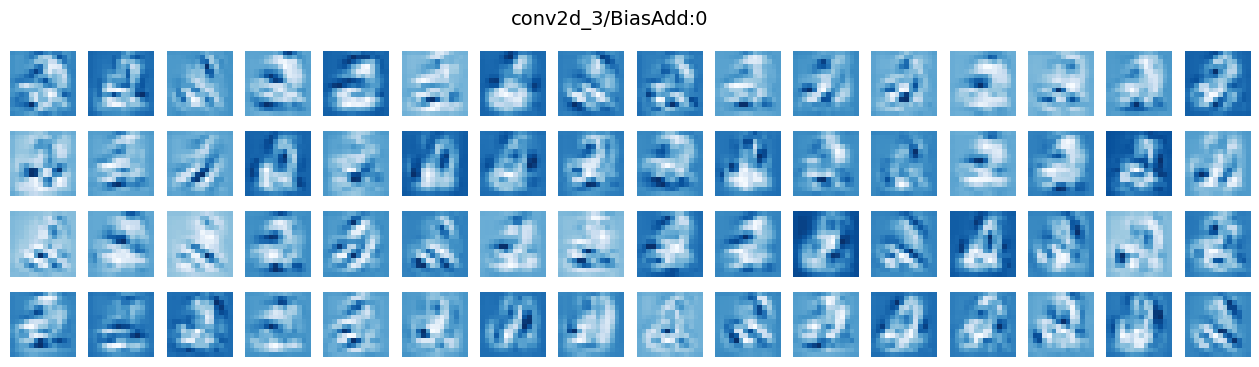

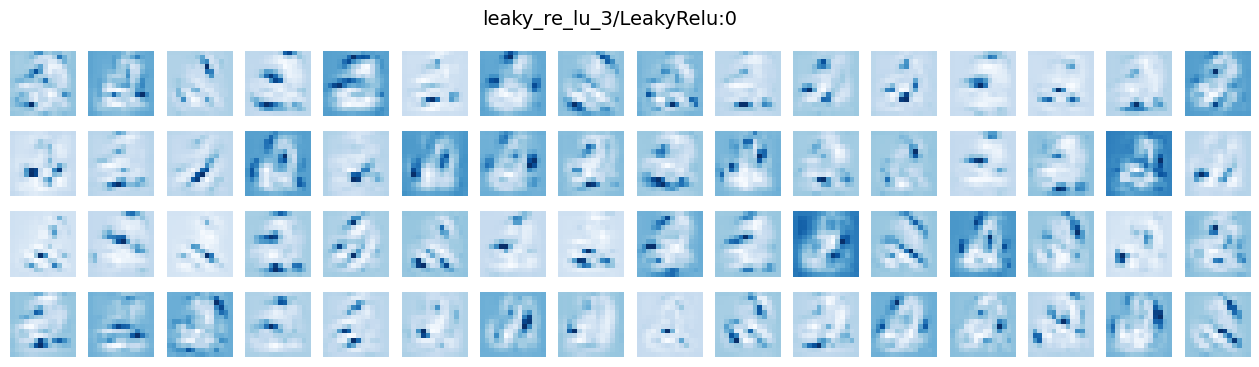

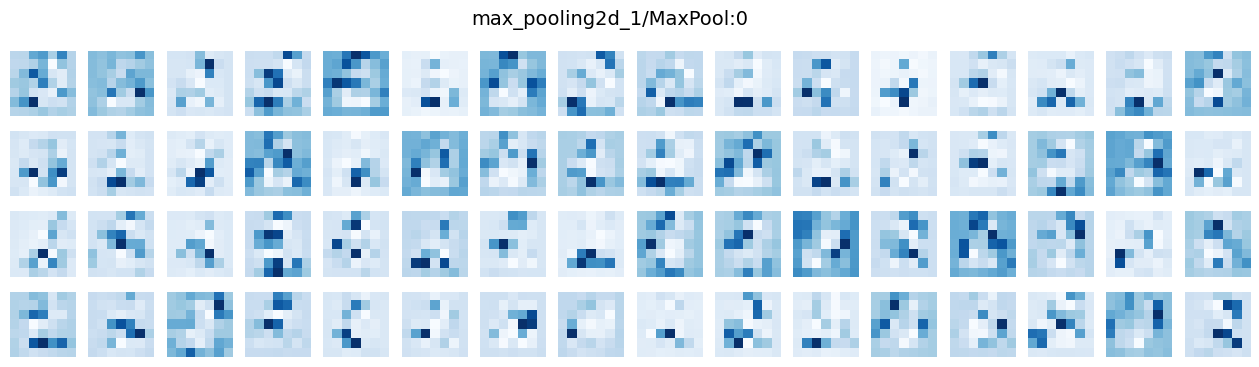

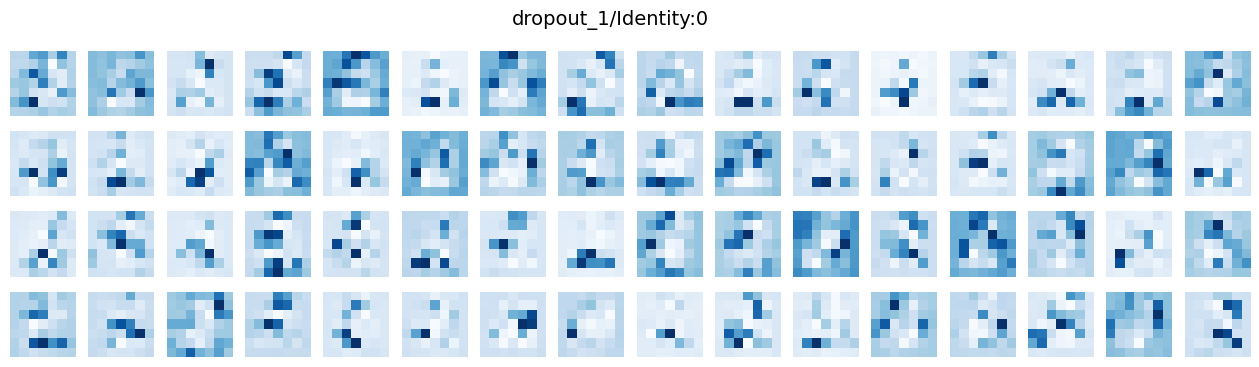

In [ ]:
# Visualising each layers
for i,layer in enumerate(activation_model.predict(val_x[6].reshape([1,28,28,1]))):
    plot_layer(layer,i,output_layers[i].name)

# Submission

In [ ]:
df_submission = pd.DataFrame([df_test.index+1,test_y],["ImageId","Label"]).transpose()
df_submission.to_csv("submission.csv",index=False)